# Shoe Sandal Boot Classification

## Reference
- [Dataset Link](https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images)

## Outline
- Prepare Notebook
- Explore Dataset
- Load and Preprocess Dataset
- Config GPU
- CNN
    - Define Model
    - Model Training
    - Evaluation
    - Testing
- RESNET
    - Define Model
    - Model Training
    - Evaluation
    - Testing

## Motive
- To compare CNN and RESNET
- Get to know lifecyle of Deep Learning
- Get to know Neural Network architecture

### Prepare Notebook

First Let's import packages, we are going to use.

In [1]:
# Importing Necessary Packages
import os
import random
from PIL import Image

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader

import warnings
warnings.filterwarnings('ignore')

### Explore Dataset

Before loading our dataset, Let's explore it, Because we get to know some information about the Images.

In [5]:
# First Exploring Parent Directory

PARENT_DIR = '/kaggle/input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset/'

print(f"Parent Directory Contains: {os.listdir(PARENT_DIR)}")

Parent Directory Contains: ['Shoe', 'Sandal', 'Boot']


In [6]:
# Second Exploring Sub-Folder's Lenght

for i in os.listdir(PARENT_DIR):
    print(f"{i} Folder's Length {len(os.listdir(PARENT_DIR + i))}")

Shoe Folder's Length 5000
Sandal Folder's Length 5000
Boot Folder's Length 5000


In [19]:
def plotRandomImage(subFolder):
    """Function Plot Random Image from give sub-folder"""
    path = PARENT_DIR + subFolder
    randInt = random.randrange(0, len(path))
    data = os.listdir(path)
    img = Image.open(path + '/' + data[randInt])
    print(f'Image Size: {img.size}')
    return img

Image Size: (136, 102)


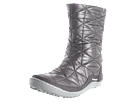

In [20]:
# Plotting Image from Boot

plotRandomImage('Boot')

Image Size: (136, 102)


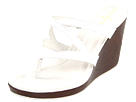

In [21]:
# Plotting Image from Sandal

plotRandomImage('Sandal')

Image Size: (136, 102)


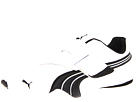

In [23]:
# Plotting Image from Shoe

plotRandomImage('Shoe')

*Key Insight*
- On Exploring
    - We get to know that parent directory contains three sub-folders ( Show, Sandal, Boots).
    - Each Sub Folder contains equal amount of images i.e 5000.
    - Every image is at same size i.e (136, 102).

- Methods
    - Resize every images to (100, 100).
    - Use Regularization Methods.
    - Convert to Tensor.

### Load and Preprocess Dataset

Now that we got some information about the dataset, let's apply some transformation and convert it to tensor

In [35]:
# Applying Regularization to Images

dataTransform = tt.Compose([
    tt.Resize(100),
    tt.RandomCrop(80),
    tt.RandomHorizontalFlip(),
    tt.ToTensor()
])

In [54]:
# Converting ImageFolder to Dataset

dataset = ImageFolder(PARENT_DIR, transform = dataTransform)
classes = dataset.classes

print(f"Classes of Dataset: {classes}")
print(f"Length of Dataset: {len(dataset)}")

Classes of Dataset: ['Boot', 'Sandal', 'Shoe']
Length of Dataset: 15000


Now that we applied some changes and it's converted from `PIL Image` to `Tensors`, Let's check the shape of the Image and Plot those images

In [37]:
# Checking Shape of Tensors

for i in [3, 33, 333, 3333]:
    img, label = dataset[i]
    print(f"Image Shape of {label}: {img.size()}")

Image Shape of 0: torch.Size([3, 80, 80])
Image Shape of 0: torch.Size([3, 80, 80])
Image Shape of 0: torch.Size([3, 80, 80])
Image Shape of 0: torch.Size([3, 80, 80])


In [65]:
def plotTensor(num):
    """Function to Plot Tensors"""
    img, label = dataset[num]
    print(f'Label is {classes[label]}')
    plt.imshow(img.permute((1, 2, 0)))
    plt.show()

Label is Boot


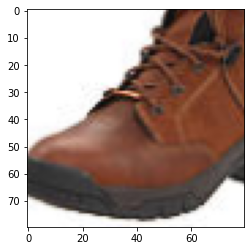

In [66]:
plotTensor(44)

Label is Shoe


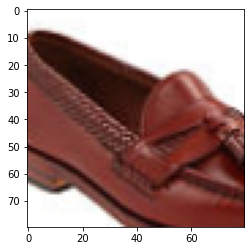

In [67]:
plotTensor(12000)

Label is Sandal


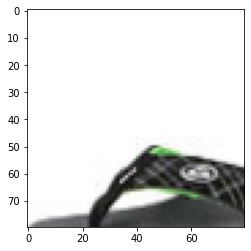

In [68]:
plotTensor(5555)

So now we load Images and Plotted our transformation. Now let's split into `Training` and `Validation` dataset. We just going to use **2%** of the Original Dataset. For testing we take images from the *internet*.

In [72]:
# Splitting original dataset 80% for training and 20% for validation

valSize = int(len(dataset) * 0.2)
trainSize = int(len(dataset) - valSize)

trainDs, valDs = random_split(dataset, [trainSize, valSize])
len(trainDs), len(valDs)

(12000, 3000)

Now let's create DataLoader with our Datasets

In [76]:
# Creating DataLoader with batch size as 128

batchSize = 128

trainLoader = DataLoader(
    trainDs,
    batch_size = batchSize,
    shuffle = True,
    num_workers = 4,
    pin_memory = True
)

valLoader = DataLoader(
    valDs,
    batch_size = batchSize,
    shuffle = True,
    num_workers = 4,
    pin_memory = True
)

Let's plot a batch from each dataloader

In [77]:
def plotBatch(dataLoader):
    """Function to plot One Batch from Dataloader"""
    for images, labels in dataLoader:
        fig, ax = plt.subplots(figsize = (16, 10))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute((1, 2, 0)))
        break

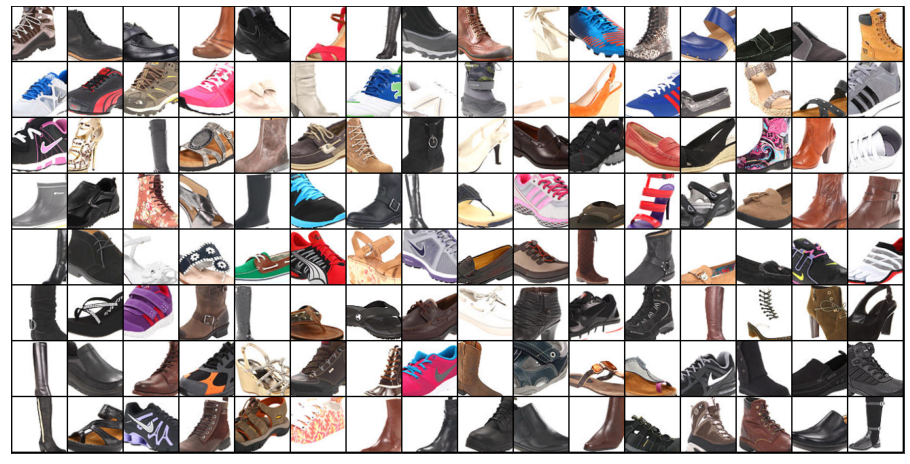

In [78]:
plotBatch(trainLoader)

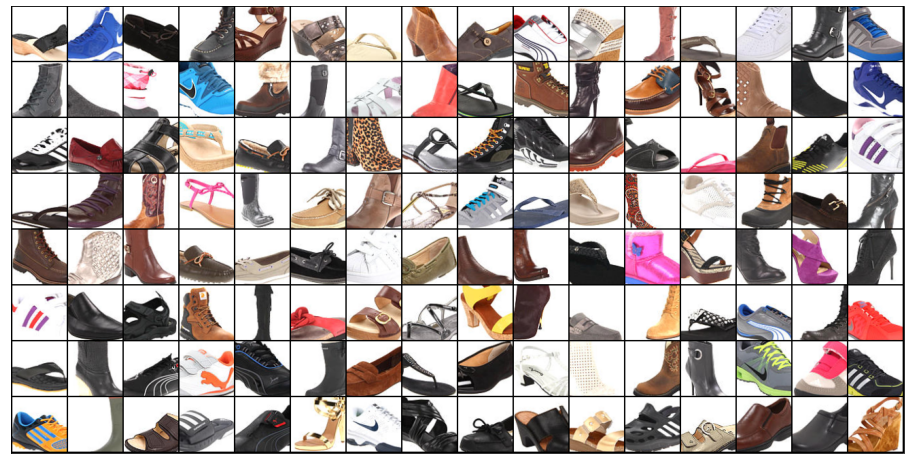

In [79]:
plotBatch(valLoader)

### Config GPU

Let's make our code work on both `CPU` and `GPU`

In [82]:
def getDevice():
    """Function to Get available device"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

def toDevice(data, device):
    """Function to convert data to given device"""
    if isinstance(data, (list, tuple)):
        return [toDevice(x, device) for x in data]
    return data.to(device, non_blocking = True)

# Class for Converting DataLoader to Given device

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yielding Batch of Images"""
        for batch in self.dl:
            yield toDevice(batch, self.device)
    
    def __len__(self):
        """Function to return the length of DataLoader"""
        return len(self.dl)

Let's check for conversion and availability by a sample dataset

In [84]:
for images, _ in trainLoader:
    print(f"Before Conversion: {images.device}")
    images = toDevice(images, getDevice())
    print(f"After Convertion: {images.device}")
    break

Before Conversion: cpu
After Convertion: cuda:0


Conversion Successuful. let's change the whole dataloader

In [85]:
device = getDevice()

trainLoader = DeviceDataLoader(trainLoader, device)
valLoader = DeviceDataLoader(valLoader, device)